<a href="https://colab.research.google.com/github/jiucai233/nlpw6hw/blob/main/3_glove_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Prerequisites

In [50]:
!pip install seaborn -q
!pip install matplotli -q
!pip install koreanize_matplotlib -q

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import re
import math
import string
import koreanize_matplotlib
import scipy.sparse as sparse
from collections import defaultdict, Counter
import seaborn as sns
# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline
# from konlpy.tag import Okt


ERROR: Could not find a version that satisfies the requirement matplotli (from versions: none)
ERROR: No matching distribution found for matplotli


# 1. 말뭉치 전처리 (Corpus Preprocessing)

이 노트북에서는 자연어 처리의 기본이 되는 말뭉치(corpus) 전처리 과정을 다룹니다. n-gram 모델과 GloVe 임베딩을 구현하기 위한 기초 작업입니다.

## 학습 목표
- 텍스트 데이터를 불러오고 전처리하는 방법 익히기
- 토큰화(tokenization)와 정제(cleaning) 과정 이해하기
- 전처리된 데이터를 후속 분석에 적합한 형태로 저장하기

In [55]:
korean_stopwords = [
    '은', '는', '이', '가', '을', '를', '와', '과', '의', '에', '에서', '으로', '로', '하고', '하는','하며', '지만', '면', '면서',
    '거나', '이다', '라고', '이라', '등', '등등', '저', '그', '이것', '것', '수', '것입니다', '또한', '그리고', '합니다', '입니다', '습니다'
]

In [56]:
# 샘플 말뭉치 파일 불러오기 (없으면 샘플 생성)
try:
    with open('corpus.txt', 'r', encoding='utf-8') as f:
        corpus = f.read()
except FileNotFoundError:
    with open('corpus.txt', 'w', encoding='utf-8') as f:
        f.write(corpus)

print(f"말뭉치 크기: {len(corpus)} 문자")
print("\n샘플 텍스트:")
print(corpus[:300] + "...")
def preprocess_text(text):
    # 줄바꿈 및 여러 공백 처리
    text = re.sub(r'\s+', ' ', text)

    # 문장 분리 (마침표, 물음표, 느낌표 기준)
    sentences = re.split(r'[.!?]\s', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # 각 문장에서 특수문자 제거 및 토큰화
    tokenized_sentences = []
    for sentence in sentences:
        # 특수문자 제거 (한글, 영문, 숫자, 공백만 유지)
        clean_sentence = re.sub(r'[^\w\s가-힣]', '', sentence)
        # 토큰화 (공백 기준)
        tokens = clean_sentence.split()
        preprocessed_sentences = []

        print(tokens)
        for word in tokens:
            for stopword in korean_stopwords:
                if word.endswith(stopword):
                    word = word[:-len(stopword)]
                    break
            preprocessed_sentences.append(word)
        tokenized_sentences.append(preprocessed_sentences)


    return tokenized_sentences

# 전처리 적용
tokenized_corpus = preprocess_text(corpus)
# 결과 확인
print(f"전처리된 문장 수: {len(tokenized_corpus)}")
for i, sentence in enumerate(tokenized_corpus[:3]):
    print(f"문장 {i+1}: {sentence}")

말뭉치 크기: 1621 문자

샘플 텍스트:
문학은 학문이 아니며, 문자를 사용한 예술의 한 분야이다. 대한민국에서는 문학진흥법에 문학을 예술의 하위 분야라고 엄중히 규정하고 있으며, 문화체육관광부 역시 문학을 예술의 하위분야로 규정한다.## 대한민국예술원법에 따라 대한민국예술원에도 역시 문학 분과가 포함되어 있다. 하지만 뒤에 학자 하나 잘못 붙어 버려 학문과 개념이 쉽게 혼동된다. 그래서 따지면 원래 더 옳을 만한 말은 '문자 예술'의 뜻을 가진 문예 정도가 될 것이다.[1] 가끔 '문학 이론'을 문학이라고 부르고 문학 작품들은 문학 이론을 써서 만들어낸 공예품 비슷한 걸...
['문학은', '학문이', '아니며', '문자를', '사용한', '예술의', '한', '분야이다']
['대한민국에서는', '문학진흥법에', '문학을', '예술의', '하위', '분야라고', '엄중히', '규정하고', '있으며', '문화체육관광부', '역시', '문학을', '예술의', '하위분야로', '규정한다', '대한민국예술원법에', '따라', '대한민국예술원에도', '역시', '문학', '분과가', '포함되어', '있다']
['하지만', '뒤에', '학자', '하나', '잘못', '붙어', '버려', '학문과', '개념이', '쉽게', '혼동된다']
['그래서', '따지면', '원래', '더', '옳을', '만한', '말은', '문자', '예술의', '뜻을', '가진', '문예', '정도가', '될', '것이다1', '가끔', '문학', '이론을', '문학이라고', '부르고', '문학', '작품들은', '문학', '이론을', '써서', '만들어낸', '공예품', '비슷한', '걸로', '보는', '모양이지만', '대부분의', '기관에선', '백이면', '백', '예술', '장르', '중', '하나로', '받아들이고', '사전적', '정의로도', '그렇게', '나와', '있다']
['문학', '이론', '역시', '문예학이라고', '불러야', '된다는', '입장도', '있다']
[

In [57]:
def build_vocabulary(tokenized_sentences):
    # 모든 단어 수집
    all_words = [word for sentence in tokenized_sentences for word in sentence]

    # 단어 빈도 계산
    word_counts = Counter(all_words)

    # 빈도순으로 정렬 (가장 빈번한 것부터)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # 단어에 ID 할당 (빈도순)
    word_to_id = {word: i for i, (word, _) in enumerate(sorted_words)}
    id_to_word = {i: word for word, i in word_to_id.items()}

    return word_to_id, id_to_word, word_counts

word_to_id, id_to_word, word_counts = build_vocabulary(tokenized_corpus)

# 어휘 사전 정보 출력
vocab_size = len(word_to_id)
print(f"어휘 사전 크기: {vocab_size} 단어")
print("\n가장 빈번한 단어 10개:")
for word, count in list(word_counts.most_common(10)):
    print(f"{word}: {count}회")

어휘 사전 크기: 263 단어

가장 빈번한 단어 10개:
문학: 22회
학문: 7회
예술: 6회
말: 6회
: 5회
있다: 4회
문예: 4회
이론: 4회
국어국문학과: 4회
국문학: 4회


In [58]:
import pickle

# 전처리 결과 저장
preprocessing_results = {
    'tokenized_corpus': tokenized_corpus,
    'word_to_id': word_to_id,
    'id_to_word': id_to_word,
    'word_counts': word_counts
}

with open('preprocessing_results.pkl', 'wb') as f:
    pickle.dump(preprocessing_results, f)

print("전처리 결과가 'preprocessing_results.pkl' 파일에 저장되었습니다.")

전처리 결과가 'preprocessing_results.pkl' 파일에 저장되었습니다.


# 3. GloVe를 위한 동시출현 행렬 구축

이 노트북에서는 GloVe(Global Vectors for Word Representation) 모델 구현을 위한 동시출현 행렬(Co-occurrence Matrix)을 구축합니다.

## 학습 목표
- 단어 동시출현 행렬의 개념 이해하기
- 윈도우 기반 동시출현 행렬 구축하기
- 희소 행렬(sparse matrix)을 사용하여 메모리 효율적으로 저장하기
- 동시출현 통계 시각화 및 분석하기

## 3.1 전처리 결과 불러오기

이전 노트북에서 저장한 전처리 결과와 n-gram 결과를 불러옵니다.

In [59]:
# 전처리 결과 불러오기
try:
    with open('preprocessing_results.pkl', 'rb') as f:
        preprocessing_results = pickle.load(f)

    tokenized_corpus = preprocessing_results['tokenized_corpus']
    word_to_id = preprocessing_results['word_to_id']
    id_to_word = preprocessing_results['id_to_word']
    word_counts = preprocessing_results['word_counts']

    print("전처리 결과를 성공적으로 불러왔습니다.")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
    print(f"문장 수: {len(tokenized_corpus)}")
except FileNotFoundError:
    print("전처리 결과 파일을 찾을 수 없습니다. 먼저 '1_corpus_preprocessing.ipynb'를 실행해주세요.")

# n-gram 결과 불러오기 (옵션)
try:
    with open('ngram_results.pkl', 'rb') as f:
        ngram_results = pickle.load(f)

    bigrams = ngram_results['bigrams']
    print("n-gram 결과를 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("n-gram 결과 파일을 찾을 수 없습니다. 필요한 경우 '2_ngram_model.ipynb'를 실행해주세요.")

전처리 결과를 성공적으로 불러왔습니다.
어휘 사전 크기: 263 단어
문장 수: 23
n-gram 결과 파일을 찾을 수 없습니다. 필요한 경우 '2_ngram_model.ipynb'를 실행해주세요.


## 3.2 GloVe 동시출현 행렬 구축

GloVe 모델에서는 단어의 동시출현(co-occurrence) 통계를 사용합니다. 이는 n-gram 모델에서 사용한 동시출현 행렬과 유사하지만, 윈도우 크기가 다를 수 있습니다.

이 구현에서는 다음 단계로 동시출현 행렬을 구축합니다:
1. 모든 문장에 대해 이동 윈도우(sliding window)를 적용
2. 윈도우 내의 모든 단어 쌍에 대해 동시출현 빈도 계산
3. 중심 단어로부터의 거리에 따라 가중치 적용 (거리가 멀수록 낮은 가중치)

In [60]:
def build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=2, weight_mode= None):
    """GloVe 모델을 위한 동시출현 행렬을 구축하는 함수

    Args:
        tokenized_corpus: 토큰화된 말뭉치
        word_to_id: 단어-ID 매핑 딕셔너리
        window_size: 중심 단어 좌우의 윈도우 크기
        weight_mode: 가중치 적용 방식 (None, 'expo', 'gaussian')

    Returns:
        희소 행렬 형태의 동시출현 행렬
    """
    vocab_size = len(word_to_id)
    cooccurrence_dict = defaultdict(float)

    # 모든 문장에 대해 반복
    for sentence in tokenized_corpus:
        # 문장의 길이
        sentence_length = len(sentence)

        # 문장의 각 위치에 대해 반복
        for i, center_word in enumerate(sentence):
            # 중심 단어가 어휘 사전에 없는 경우 건너뜀
            if center_word not in word_to_id:
                continue

            center_id = word_to_id[center_word]

            # 윈도우 내의 단어들에 대해 반복
            window_start = max(0, i - window_size)
            window_end = min(sentence_length, i + window_size + 1)

            for j in range(window_start, window_end):
                # 중심 단어 자신은 건너뜀
                if i == j:
                    continue

                context_word = sentence[j]

                # 문맥 단어가 어휘 사전에 없는 경우 건너뜀
                if context_word not in word_to_id:
                    continue

                context_id = word_to_id[context_word]

                if weight_mode == None:
                # 거리에 따른 가중치 계산 (거리가 멀수록 낮은 가중치)
                  distance = abs(j - i)
                  weight = 1.0 / distance

                elif weight_mode == "expo":
                  distance = abs(j - i)
                  gamma = 0.5  #adjustable hyperparameter
                  weight = math.exp(-gamma * distance)

                elif weight_mode == "gaussian":
                  distance = abs(j - i)
                  sigma = 2.0
                  weight = math.exp(-(distance ** 2) / (2 * sigma ** 2))

                else:
                  raise ValueError("Unknown weight_mode. Choose None, 'expo', or 'gaussian'.")

                # 동시출현 빈도 증가 (가중치 적용)
                cooccurrence_dict[(center_id, context_id)] += weight

    # 희소 행렬 생성을 위한 데이터 준비
    row_indices = []
    col_indices = []
    data = []

    for (i, j), value in cooccurrence_dict.items():
        row_indices.append(i)
        col_indices.append(j)
        data.append(value)

    # CSR 형식의 희소 행렬 생성
    cooccurrence_matrix = sparse.csr_matrix((data, (row_indices, col_indices)),
                                            shape=(vocab_size, vocab_size))

    return cooccurrence_matrix

# GloVe 동시출현 행렬 구축
window_size = 2  # 윈도우 크기 설정
cooccurrence_matrix_glove = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=3, weight_mode="gaussian")

print(f"GloVe 동시출현 행렬 크기: {cooccurrence_matrix_glove.shape}")
print(f"총 동시출현 빈도: {cooccurrence_matrix_glove.sum():.2f}")
print(f"0이 아닌 원소 수: {cooccurrence_matrix_glove.nnz}")
print(f"희소성 (sparsity): {(1 - cooccurrence_matrix_glove.nnz / (cooccurrence_matrix_glove.shape[0] * cooccurrence_matrix_glove.shape[1])) * 100:.2f}%")

GloVe 동시출현 행렬 크기: (263, 263)
총 동시출현 빈도: 1132.01
0이 아닌 원소 수: 1740
희소성 (sparsity): 97.48%


## 3.3 동시출현 통계 시각화

특정 단어들의 동시출현 패턴을 시각화합니다.

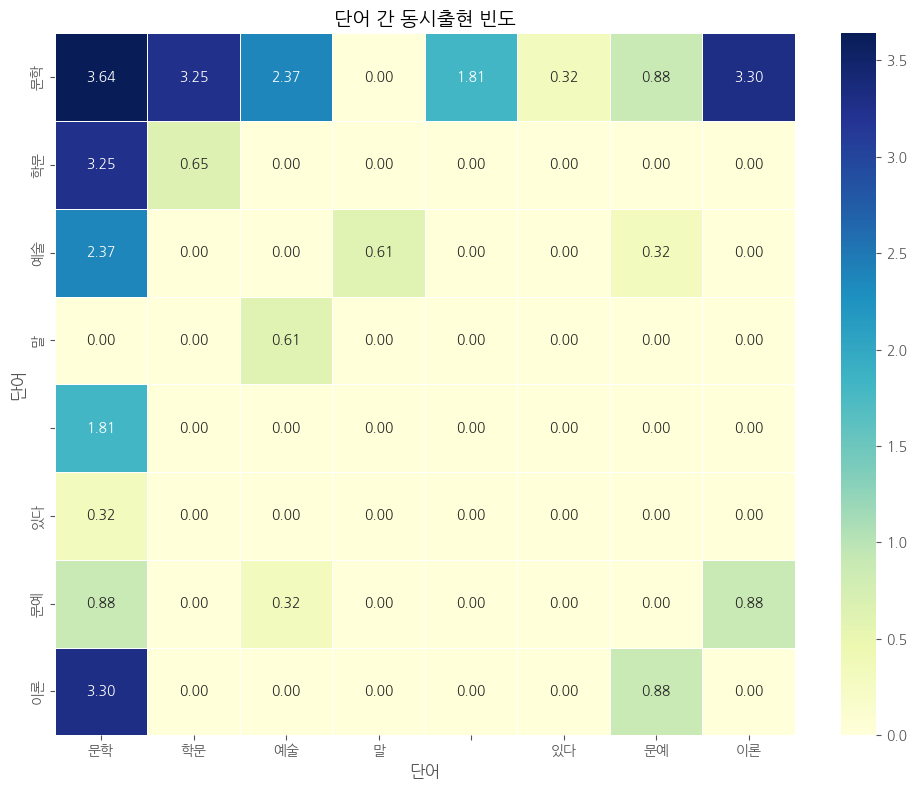

In [61]:
def visualize_cooccurrence_heatmap(cooccurrence_matrix, word_to_id, id_to_word, target_words, figsize=(10, 8)):
    """특정 단어들의 동시출현 패턴을 히트맵으로 시각화하는 함수

    Args:
        cooccurrence_matrix: 동시출현 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        id_to_word: ID-단어 매핑 딕셔너리
        target_words: 시각화할 단어 목록
        figsize: 그림 크기
    """
    # 대상 단어들의 ID 리스트
    target_ids = []
    for word in target_words:
        try:
            target_ids.append(word_to_id[word])
        except KeyError:
            print(f"단어 '{word}'를 어휘 사전에서 찾을 수 없습니다.")

    if not target_ids:
        print("시각화할 단어가 없습니다.")
        return

    # 대상 단어들만의 부분 행렬 추출
    sub_matrix = cooccurrence_matrix[target_ids, :][:, target_ids].toarray()

    # 히트맵 시각화
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(sub_matrix, annot=True, fmt=".2f", linewidths=0.5,
                xticklabels=[id_to_word[i] for i in target_ids],
                yticklabels=[id_to_word[i] for i in target_ids],
                cmap="YlGnBu", ax=ax)
    plt.title("단어 간 동시출현 빈도", fontsize=14)
    plt.xlabel("단어", fontsize=12)
    plt.ylabel("단어", fontsize=12)
    plt.tight_layout()
    plt.show()

# 특정 단어들의 동시출현 패턴 시각화
# 가장 빈번한 단어들 중 일부 선택
most_common_words = [word for word, _ in word_counts.most_common(10)]
most_common_words = [word for word, _ in word_counts.most_common(10)]
target_words = most_common_words[:8]  # 상위 8개 단어
visualize_cooccurrence_heatmap(cooccurrence_matrix_glove, word_to_id, id_to_word, target_words)

## 3.4 특정 단어 쌍의 동시출현 빈도 분석

특정 단어와 가장 자주 동시출현하는 단어들을 찾고 분석합니다.


'문학'와 가장 자주 동시출현하는 단어들:
  이론: 3.30
  학문: 3.25
  예술: 2.37
  역시: 2.37
  아동: 2.09
  노동자: 2.09
  : 1.81
  작품들: 1.76
  근대: 1.76
  부르고: 1.53


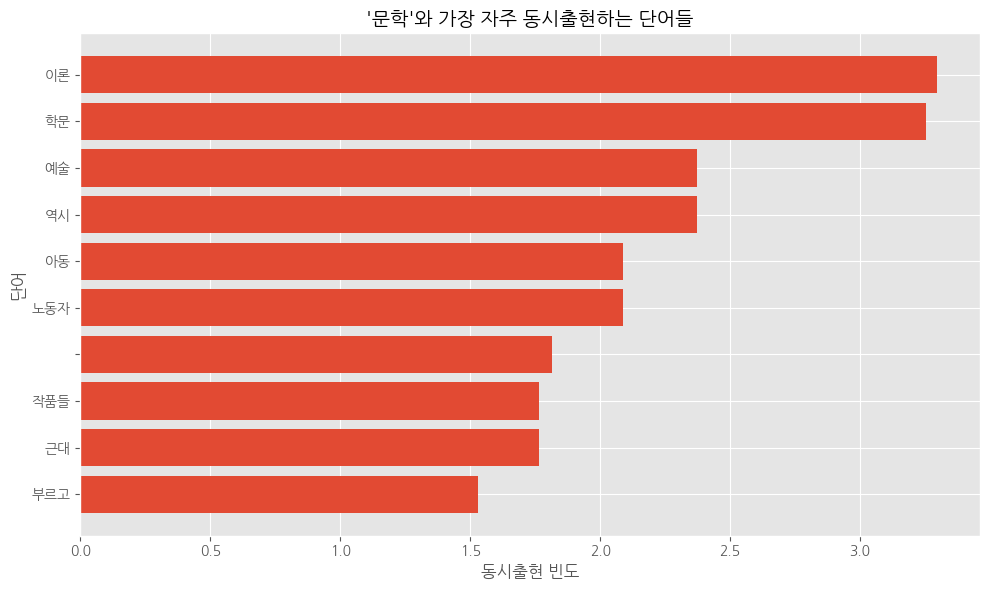


'학문'와 가장 자주 동시출현하는 단어들:
  아닌: 1.49
  연구하: 0.88
  개념: 0.88
  버려: 0.88
  아니며: 0.88
  아님에도: 0.88
  받아들일: 0.88
  기류: 0.88
  뜻하: 0.88
  뜻한다: 0.88


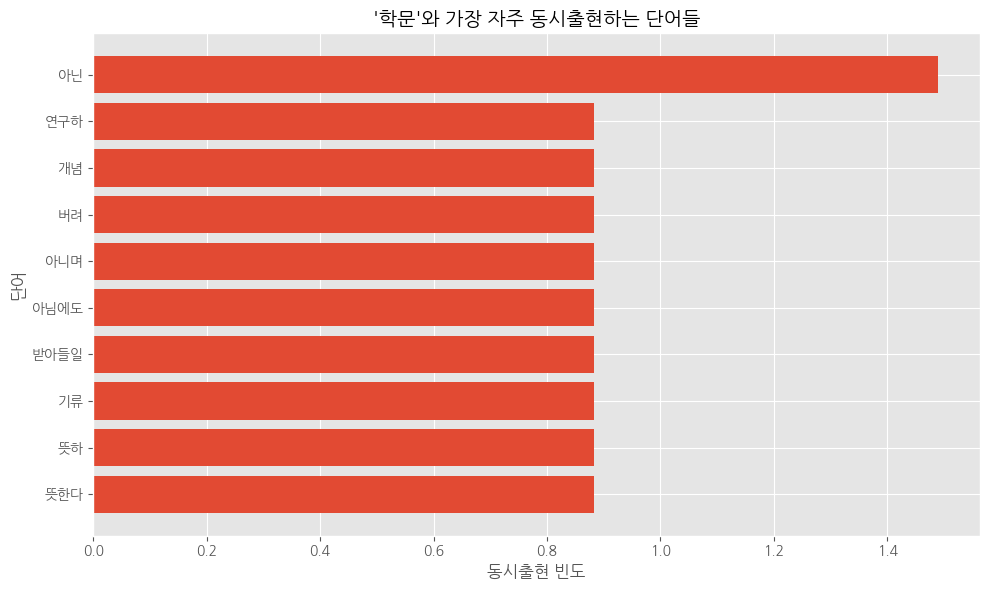


'예술'와 가장 자주 동시출현하는 단어들:
  문자: 1.49
  백: 1.49
  분야: 1.21
  포함한: 0.88
  하위분야: 0.88
  하위: 0.88
  한: 0.88
  흑: 0.88
  뜻: 0.88
  장르: 0.88


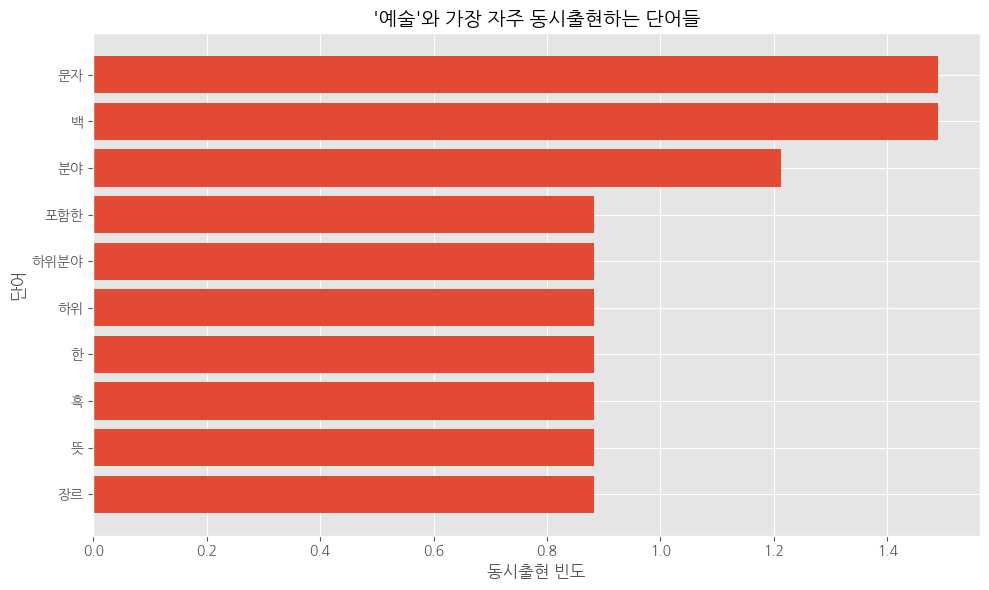

In [62]:
def find_top_cooccurring_words(word, cooccurrence_matrix, word_to_id, id_to_word, top_n=10):
    """특정 단어와 가장 자주 동시출현하는 단어들을 찾는 함수

    Args:
        word: 대상 단어
        cooccurrence_matrix: 동시출현 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        id_to_word: ID-단어 매핑 딕셔너리
        top_n: 상위 몇 개의 단어를 반환할지 결정

    Returns:
        상위 동시출현 단어와 빈도의 리스트
    """
    try:
        word_id = word_to_id[word]
    except KeyError:
        print(f"단어 '{word}'를 어휘 사전에서 찾을 수 없습니다.")
        return []

    # 해당 단어의 동시출현 벡터 추출
    cooccurrence_vec = cooccurrence_matrix[word_id].toarray().flatten()

    # 동시출현 빈도가 높은 상위 단어 인덱스 (자기 자신 제외)
    top_indices = np.argsort(cooccurrence_vec)[-top_n-1:-1][::-1]

    # 결과 생성
    result = []
    for idx in top_indices:
        if cooccurrence_vec[idx] > 0:  # 빈도가 0인 경우 제외
            result.append((id_to_word[idx], cooccurrence_vec[idx]))

    return result

def visualize_top_cooccurring_words(word, top_cooccurring, figsize=(10, 6)):
    """특정 단어와 가장 자주 동시출현하는 단어들을 막대 그래프로 시각화하는 함수"""
    if not top_cooccurring:
        return

    words, freqs = zip(*top_cooccurring)

    plt.figure(figsize=figsize)
    plt.barh(words, freqs)
    plt.title(f"'{word}'와 가장 자주 동시출현하는 단어들", fontsize=14)
    plt.xlabel('동시출현 빈도', fontsize=12)
    plt.ylabel('단어', fontsize=12)
    plt.gca().invert_yaxis()  # 빈도가 높은 단어를 위쪽에 표시
    plt.tight_layout()
    plt.show()

# 예시: 특정 단어들에 대한 동시출현 분석
example_words = most_common_words[:3]  # 상위 3개 단어
for word in example_words:
    top_cooccurring = find_top_cooccurring_words(word, cooccurrence_matrix_glove, word_to_id, id_to_word)
    print(f"\n'{word}'와 가장 자주 동시출현하는 단어들:")
    for cooccurring_word, freq in top_cooccurring:
        print(f"  {cooccurring_word}: {freq:.2f}")
    visualize_top_cooccurring_words(word, top_cooccurring)

## 3.5 동시출현 행렬의 특성 분석

동시출현 행렬의 전체적인 특성과 분포를 분석합니다.

동시출현 행렬 통계:
  총 동시출현 빈도: 1132.01
  0이 아닌 원소 수: 1740
  최대값: 3.64
  최소값 (0 제외): 0.32
  평균값 (0 제외): 0.65
  중앙값 (0 제외): 0.61


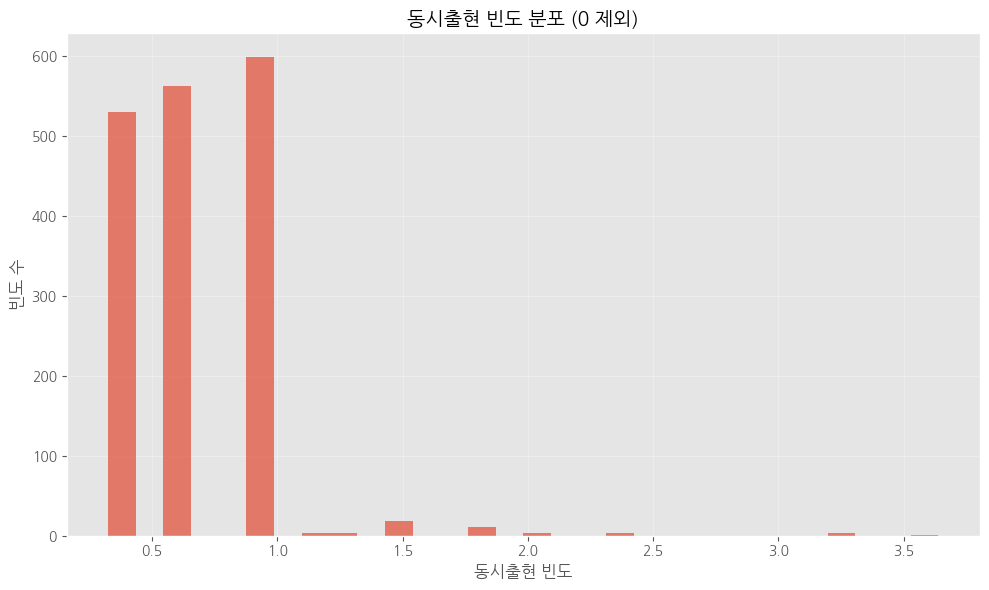

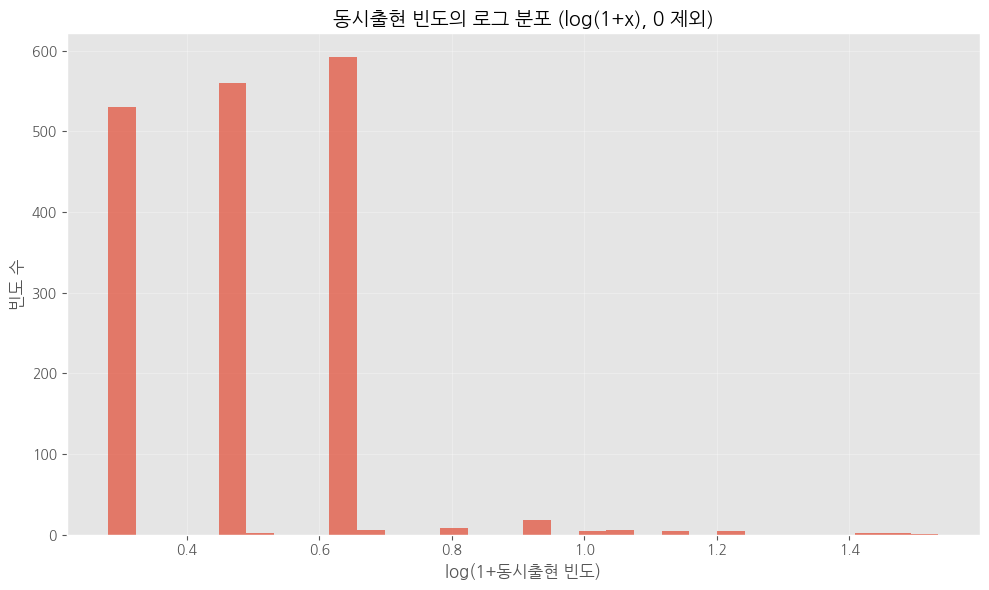

In [63]:
def analyze_cooccurrence_matrix(cooccurrence_matrix):
    """동시출현 행렬의 특성을 분석하는 함수

    Args:
        cooccurrence_matrix: 동시출현 행렬
    """
    # 행렬을 밀집 형태로 변환 (메모리 사용량 주의)
    dense_matrix = cooccurrence_matrix.toarray()

    # 기본 통계량
    non_zero_values = dense_matrix[dense_matrix > 0]

    print("동시출현 행렬 통계:")
    print(f"  총 동시출현 빈도: {cooccurrence_matrix.sum():.2f}")
    print(f"  0이 아닌 원소 수: {len(non_zero_values)}")
    print(f"  최대값: {non_zero_values.max():.2f}")
    print(f"  최소값 (0 제외): {non_zero_values.min():.2f}")
    print(f"  평균값 (0 제외): {non_zero_values.mean():.2f}")
    print(f"  중앙값 (0 제외): {np.median(non_zero_values):.2f}")

    # 동시출현 빈도 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(non_zero_values, bins=30, alpha=0.7)
    plt.title("동시출현 빈도 분포 (0 제외)", fontsize=14)
    plt.xlabel("동시출현 빈도", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 로그 스케일 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(np.log1p(non_zero_values), bins=30, alpha=0.7)
    plt.title("동시출현 빈도의 로그 분포 (log(1+x), 0 제외)", fontsize=14)
    plt.xlabel("log(1+동시출현 빈도)", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 동시출현 행렬 분석 (행렬 크기가 작을 때만 실행)
vocab_size = len(word_to_id)
if vocab_size <= 1000:  # 어휘 크기가 너무 크면 메모리 문제 발생 가능
    analyze_cooccurrence_matrix(cooccurrence_matrix_glove)
else:
    print(f"어휘 크기({vocab_size})가 너무 커서 동시출현 행렬 분석을 건너뜁니다.")

## 3.6 결과 저장

다음 단계인 GloVe 손실 함수 구현을 위해 동시출현 행렬을 저장합니다.

In [64]:
# 결과 저장
glove_matrix_results = {
    'cooccurrence_matrix': cooccurrence_matrix_glove,
    'window_size': window_size
}

with open('glove_matrix_results.pkl', 'wb') as f:
    pickle.dump(glove_matrix_results, f)

print("GloVe 동시출현 행렬 결과가 'glove_matrix_results.pkl' 파일에 저장되었습니다.")

GloVe 동시출현 행렬 결과가 'glove_matrix_results.pkl' 파일에 저장되었습니다.


## 3.7 요약 및 다음 단계

이 노트북에서는 GloVe 모델을 위한 동시출현 행렬을 구축하고 분석했습니다. 주요 단계는 다음과 같습니다:

1. 윈도우 기반 동시출현 행렬 구축
2. 희소 행렬을 사용하여 메모리 효율적으로 저장
3. 동시출현 패턴 시각화 및 분석
4. 특정 단어와 가장 자주 동시출현하는 단어 찾기
5. 동시출현 행렬의 특성 분석

동시출현 행렬은 GloVe 모델의 핵심 입력 데이터입니다. 이 행렬의 특성과 패턴을 이해하는 것은 워드 임베딩의 품질을 개선하는 데 중요합니다.

다음 노트북에서는 이 동시출현 행렬을 사용하여 GloVe 손실 함수를 구현하고 단어 임베딩을 학습합니다.